# Verify that the baseline curves can fit the fresh data.

04/30/2023

Andrew Weng

In [1]:
# %matplotlib widget
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

from src import cellsim as cellsim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from src import plotter as plotter
from scipy.signal import savgol_filter as savgol_filter
from src import dvdq as dvdq
from src import modelutils as mu
from scipy import interpolate

plotter.initialize(plt)

%load_ext autoreload


# Load the Experimental Data

In [2]:
plotter.initialize(plt)
target_dir = os.getcwd()
target_dir_arbin = f'{target_dir}/data/raw/from-voltaiq'
file_indices_to_include = np.array([1])

cellid = 152064

if cellid == 152064:
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                    ]

    daq_channel = 'Key_CH1'

    hr_max = 65

elif cellid == 152074: # BASELINE FORMATION (repeat 2)

    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
                    ]

    daq_channel = 'Key_CH0'

    hr_max = 65

# Load the Arbin Data
df_arbin_list = []

for file in np.array(file_arbin_list)[file_indices_to_include]:

    df = pd.read_csv(file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp']= df['Timestamp'].apply(lambda x : x.tz_localize(None))
    df_arbin_list.append(df)

df_arbin = pd.concat(df_arbin_list, axis=0)

df_arbin = df_arbin[df_arbin['Cycle Number'] == 39]
df_arbin = df_arbin[df_arbin['Step Index'] == 24]

# Filter the Arbin Data
ii = df_arbin['Current (A)']
qq = df_arbin['Charge Capacity (Ah)']
tv = df_arbin['Timestamp'].astype(int)
tt = (tv - np.min(tv)) / 1e9
vv = df_arbin['Potential (V)']

size_factor = 65
window_length = int(len(tt) / size_factor)
window_length = window_length + 1 if window_length % 2 == 0 else window_length
polyorder = 2

# SG filter on the data to make it smooth
dq1 = savgol_filter(qq, window_length, polyorder, 1)
dv1 = savgol_filter(vv, window_length, polyorder, 1)

out = dict()
out['chg_capacity'] = qq
out['chg_voltage'] = vv
out['chg_dvdq'] = dv1/dq1
df_out = pd.DataFrame(out)
df_out.to_csv(f'diagnostic_test_cell_umbl2022feb_cell{cellid}.csv')


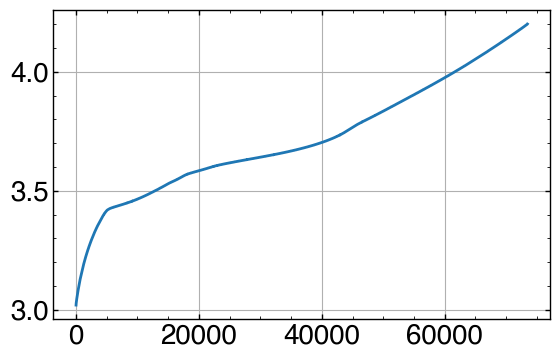

In [3]:
plt.figure(figsize=(6,4))
plt.plot(tt, vv)


# Load the Resistance Data

In [4]:
df_resistance = pd.read_csv('data/processed/hppc_1.csv')

In [5]:
%autoreload
Ichg = 2.5/10  # A
Idch = -2.5/10 # A
Icv = 2.5/20   # A

vmax = 4.2
vmin = 3.0

cell = cellsim.Cell()
cell.load_config('params/weng2021.yaml')


# Baseline Formation
sim1 = cellsim.Simulation(cell, 2000*3600)

sim1.run_rest(1, rest_time_hrs=0.5)
sim1.run_chg_cccv(2, 2.37/10, Icv, vmax)
sim1.run_dch_cccv(2, Idch, Idch, vmin)
sim1.run_chg_cccv(3, 2.37/10, Icv, vmax)
sim1.run_dch_cccv(3, Idch, Idch, vmin)
sim1.run_chg_cccv(4, 2.37/10, Icv, vmax)
sim1.run_rest(4, rest_time_hrs=6)
sim1.run_dch_cccv(4, Idch, Idch, vmin)

df_sim1 = sim1.get_results()

# Fast Formation
sim2 = cellsim.Simulation(cell, 2000*3600)

sim2.run_rest(1, rest_time_hrs=0.5)
sim2.run_chg_cccv(2, 2.37, 2.37, 3.9)
sim2.run_chg_cccv(2, 2.37/5, 2.37/100, 4.2)
sim2.run_dch_cccv(2, -2.37/5, 2.37/5, 3.9)
sim2.run_chg_cccv(3, 2.37/5, 2.37/100, 4.2)
sim2.run_dch_cccv(3, -2.37/5, 2.37/5, 3.9)
sim2.run_chg_cccv(4, 2.37/5, 2.37/100, 4.2)
sim2.run_dch_cccv(4, -2.37/5, 2.37/5, 3.9)
sim2.run_chg_cccv(5, 2.37/5, 2.37/100, 4.2)
sim2.run_dch_cccv(5, -2.37/5, 2.37/5, 3.9)
sim2.run_chg_cccv(6, 2.37/5, 2.37/100, 4.2)
sim2.run_dch_cccv(6, -2.37/5, 2.37/5, 3.9)
sim2.run_dch_cccv(6, -2.37/1, 2.37/1, 3.0)

# RPT
sim2.run_chg_cccv(6, +2.37/10, +2.37/10, vmax)
sim2.run_dch_cccv(6, -2.37/10, 2.37/10, vmin)
sim2.run_chg_cccv(7, +2.37/10, +2.37/10, vmax)
sim2.run_rest(    7, rest_time_hrs=10.6)
sim2.run_dch_cccv(7, -2.37/10, 2.37/10, vmin)

df_sim2 = sim2.get_results()


Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...
Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Rest for 6 hours...
Running Cyc4: Discharge to 3.0V...
Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 3.9V...
Running Cyc2: Charge to 4.2V...
Running Cyc2: Discharge to 3.9V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.9V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.9V...
Running Cyc5: Charge to 4.2V...
Running Cyc5: Discharge to 3.9V...
Running Cyc6: Charge to 4.2V...
Running Cyc6: Discharge to 3.9V...
Running Cyc6: Discharge to 3.0V...
Running Cyc6: Charge to 4.2V...
Running Cyc6: Discharge to 3.0V...
Running Cyc7: Charge to 4.2V...
Running Cyc7: Rest for 10.6 hours...
Running Cyc7: Discharge to 3.0V...


In [6]:
interval_skip = 150

Cp = 3.02 # Ah
Cn = 3.14

theta_n_vec = df_sim1['theta_n'][::interval_skip]
theta_p_vec = df_sim1['theta_p'][::interval_skip]
q_sei_vec   = df_sim1['q_sei'][::interval_skip]

sim1_out = (Cp, Cn, theta_p_vec, theta_n_vec, q_sei_vec)

theta_n_vec = df_sim2['theta_n'][::interval_skip]
theta_p_vec = df_sim2['theta_p'][::interval_skip]
q_sei_vec   = df_sim2['q_sei'][::interval_skip]

sim2_out = (Cp, Cn, theta_p_vec, theta_n_vec, q_sei_vec)

# Synchronize the maximum number of frames for both animations
num_frames = np.min((len(sim1_out[2]), len(sim2_out[2])))


In [17]:
def setup(type, figsize=(14,10)):
    """
    Set up the figure

    Parameters
    ----------
    type : str
       'res' for resistance plot as the second panel
       'dvdq' for dV/dQ plot as the second panel
    Returns the figure and axis handles
    """

    gridspec = dict(hspace=0.05, height_ratios=[1, 1, 1])

    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1,
                                gridspec_kw=gridspec,
                                figsize=figsize)

    ax1.set_ylim((2.5, 5))
    ax1.set_ylabel('Voltage / Potential vs Li/Li$^+$ (V)')
    ax1.set_yticks([3, 4.2])

    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.spines['bottom'].set_visible(False)

    # Initialize an empty text handle
    th1 = ax1.text(0.1, 4.2, '', fontsize=16)
    th2 = ax3.text(0.1, 80, '', fontsize=16)

    ax2.spines['top'].set_visible(False)
    ax2.set_ylim((-0.4, 1.8))
    ax2.set_yticks([0, 0.50, 1, 1.5])
    ax2.set_yticklabels([0, 0.50, 1, 1.5])
    ax2.tick_params(axis='y', colors='red')
    ax2.set_xticklabels([])
    ax2.set_xticks([])

    # ax3.yaxis.set_label_coords(-0.045, 0.00)
    ax3.set_xlabel(r'$q$ [Ah]')
    ax3.set_xticks([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])

    if type == 'res':
        ax3.set_ylabel(r'$R_{10s}$ [$m\Omega$]')
        ax3.set_ylim((0, 120))
    elif type == 'dvdq':
        ax3.set_ylabel(r'd$V$/d$q$ [V/Ah]')
        ax3.set_ylim((0, 0.6))

    # Make the split lines
    d = 0.015
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d,+d), (-d,+d), **kwargs)
    ax1.plot((1-d,1+d),(-d,+d), **kwargs)

    kwargs.update(transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot((-d,+d), (1-d,1+d), **kwargs)
    ax2.plot((1-d,1+d), (1-d,1+d), **kwargs)

    # Set shared axis settings
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim((-0.1, 3.8))
        ax.grid(False)

    fig.align_ylabels(axs=[ax1, ax2, ax3])

    ax1.yaxis.set_label_coords(-0.06, 0)

    return fig, [ax1, ax2, ax3], [th1, th2]

In [13]:
def draw(axs, type, ths, t, params):
    """
    Draw figure elements

    Parameters
    ---------
    axs: array of axis handles
    type: 'res'istance plot or 'dvdq' plot
    ths: array of text handles
    t: simulation time in seconds
    params: parameters (tuple)
    """

    # Unpack the inputs
    ax1, ax2, ax3 = axs
    Q_p, Q_n, theta_n_curr, theta_p_curr, q_sei = params
    th1, th2 = ths

    theta_vec = np.linspace(0, 1, 1000)
    # Unpack the parameters vector

    (f_rpos, f_rneg) = mu.get_resistance_curves()

    qpos = Q_p * (1 - theta_vec)
    vpos = mu.Up(theta_vec)
    rpos = f_rpos(theta_vec)
    qneg = Q_n * theta_vec + q_sei
    vneg = mu.Un(theta_vec)
    rneg = f_rneg(theta_vec)

    q_n_curr = Q_p * (1 - theta_p_curr)
    q_p_curr = Q_n * theta_n_curr + q_sei
    v_p_curr = mu.Up(theta_p_curr)
    v_n_curr = mu.Un(theta_n_curr)
    r_p_curr = f_rpos(theta_p_curr)
    r_n_curr = f_rneg(theta_n_curr)

    # Reconstruct the full cell curves from the half cell data
    f_qp = interpolate.interp1d(qpos, vpos, bounds_error=False, fill_value=np.NaN)
    f_qn = interpolate.interp1d(qneg, vneg, bounds_error=False, fill_value=np.NaN)
    f_rp = interpolate.interp1d(qpos, rpos, bounds_error=False, fill_value=np.NaN)
    f_rn = interpolate.interp1d(qneg, rneg, bounds_error=False, fill_value=np.NaN)

    qfull = np.linspace(0, Q_p, 1000)
    vfull = f_qp(qfull) - f_qn(qfull)
    rfull = f_rp(qfull) + f_rn(qfull)

    f_full_inv = interpolate.interp1d(vfull, qfull)
    qmin = f_full_inv(3.0)
    qmax = f_full_inv(4.2)
    qcell = qmax - qmin

    f_full_r = interpolate.interp1d(qfull, rfull)
    r_full_ref = f_full_r(qmin)

    # dvdq_meas = np.gradient(Voc)/np.gradient(q)*np.max(q)
    dvdq_pos = np.gradient(vpos)/np.gradient(qpos)
    dvdq_neg = np.gradient(vneg)/np.gradient(qneg)
    dvdq_full = np.gradient(vfull)/np.gradient(qfull)

    # Clear line objects
    for ax in axs:
        for l in ax.get_lines():
            l.remove()

    # Make the cathode and full cell voltage plot
    # ax1.plot(qq, vv, c='k', ls='--') # the data
    ax1.plot(qfull, vfull, c='k', ls='-')
    ax1.plot(q_p_curr, f_qp(q_p_curr) - f_qn(q_n_curr), marker='o', markersize=9, c='k')
    ax1.plot(qpos, vpos, 'b')
    ax1.plot(q_p_curr, v_p_curr, marker='o', markersize=9, c='b')

    th1.set_position((qmin+0.05, 4.2))
    th1.set_text(f'$t={t/60:.1f}$ mins \n$Q_{{\mathrm{{SEI}}}}={q_sei:.3f}$ Ah \n$Q_{{\mathrm{{cell}}}}={qcell:.3f}$ Ah')

    # Make the anode voltage plot
    ax2.plot(q_n_curr, v_n_curr, marker='o', markersize=8, c='r')
    ax2.plot(qneg, vneg, 'r')

    # Make the dV/dQ plot
    # ax3.plot(qq, dv1/dq1, c='k', ls='--')
    if type == 'dvdq':
        ax3.plot(qfull, dvdq_full, c='k', ls='-')
        ax3.plot(qpos, dvdq_pos, 'b')
        ax3.plot(qneg, -dvdq_neg, 'r')
    elif type == 'res':
        ax3.plot(qfull, rfull*1e3, c='k', ls='-')
        ax3.plot(qpos, rpos*1e3, 'b')
        ax3.plot(qneg, rneg*1e3, 'r')
        ax3.plot(q_p_curr, r_p_curr*1e3, marker='o', markersize=8, c='b')
        ax3.plot(q_n_curr, r_n_curr*1e3, marker='o', markersize=8, c='r')
        ax3.plot(qmin, r_full_ref*1e3, marker='o', markersize=8, c='k')

    th2.set_position((qmin+0.02, r_full_ref*1e3+3))
    th2.set_text(f'$R_{{\mathrm{{LS}}}} = {r_full_ref*1e3:.1f} $ m$\Omega$')

    # Vertical bars indicating 0% and 100% SOC
    for ax in axs:
        ax.axvline(x=qmin, ymin=0, ymax=100, c='k', linewidth=1, linestyle=':')
        ax.axvline(x=qmax, ymin=0, ymax=100, c='k', linewidth=1, linestyle=':')




In [9]:
def animate(idx_frame, axs, type, th, sim_out, interval_ms):
    """
    Animation function that gets iteratively called to render frames

    Parameters
    ----------
    idx_frame : int
        Frame index
    axs : np.array
        array of axis handles
    type : str
        'res' or 'dvdq'
    th : np.array
        array of text handles
    sim_out : tuple
        simulation outputs
        (Cp, Cn, theta_p_vec, theta_n_vec, q_sei_vec)
            Cp (float): cathode capacity
            Cn (float): anode capacity
            theta_p_vec (pd.Series): cathode stoichiometry
            theta_n_vec (pd.Series): anode stoichiometry
            q_sei_vec (pd.Series): SEI consumption
    interval_ms : int
        Interval between frames in milliseconds
    """

    Cp, Cn, theta_p_vec, theta_n_vec, q_sei_vec = sim_out

    theta_n_curr = theta_n_vec.iloc[idx_frame]
    theta_p_curr = theta_p_vec.iloc[idx_frame]
    q_sei = q_sei_vec.iloc[idx_frame]

    # Convert frame index to real time
    dt_sim = 5 * interval_skip # seconds
    t = (idx_frame * interval_ms / 1000) * dt_sim

    params = (Cp, Cn, theta_n_curr, theta_p_curr, q_sei)

    draw(axs, type, th, t, params)


# Draw a single frame for testing purposes

/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


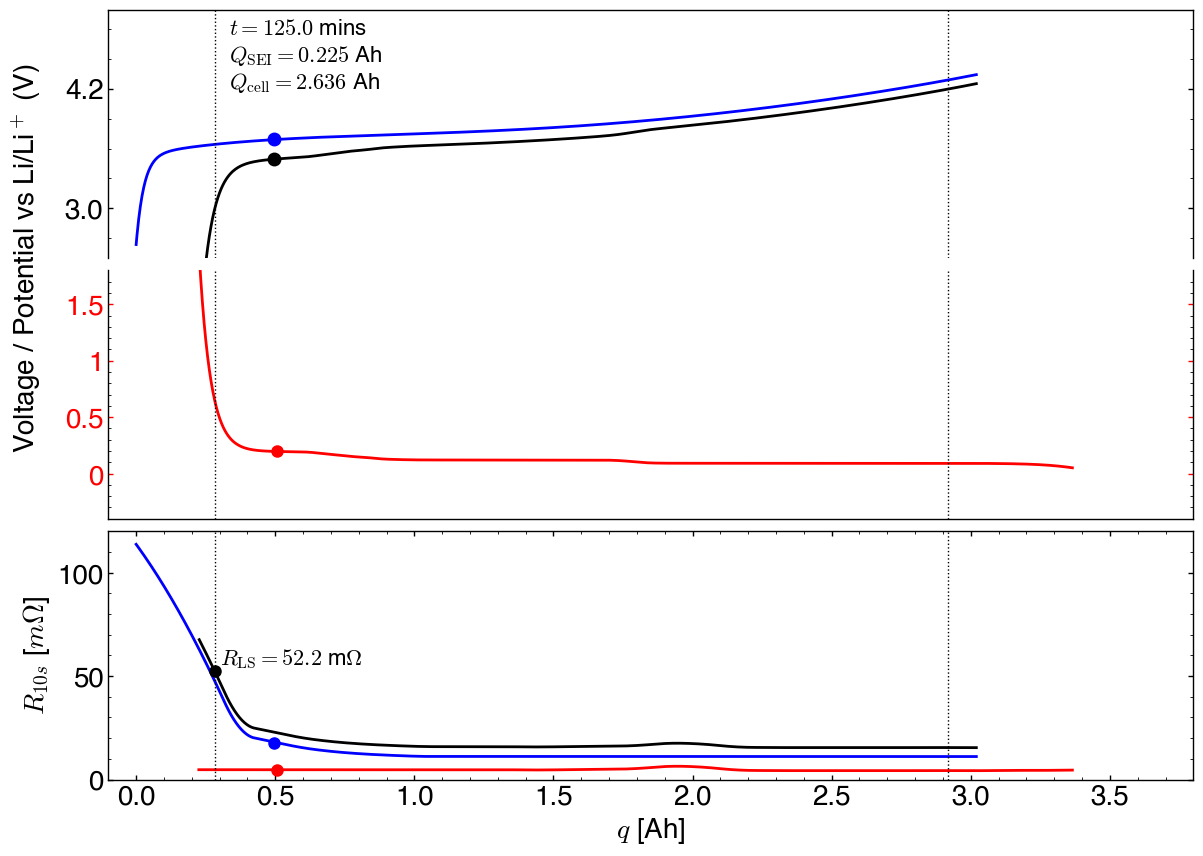

In [14]:
fig, axs, th = setup('res')

idx_frame=100

animate(idx_frame, axs, type, th, sim1_out, interval_ms=100)

Cp, Cn, theta_p_vec, theta_n_vec, q_sei = sim1_out


/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_8069/2751828874.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ani.save(r'animation_base.gif', writer=writergif)
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


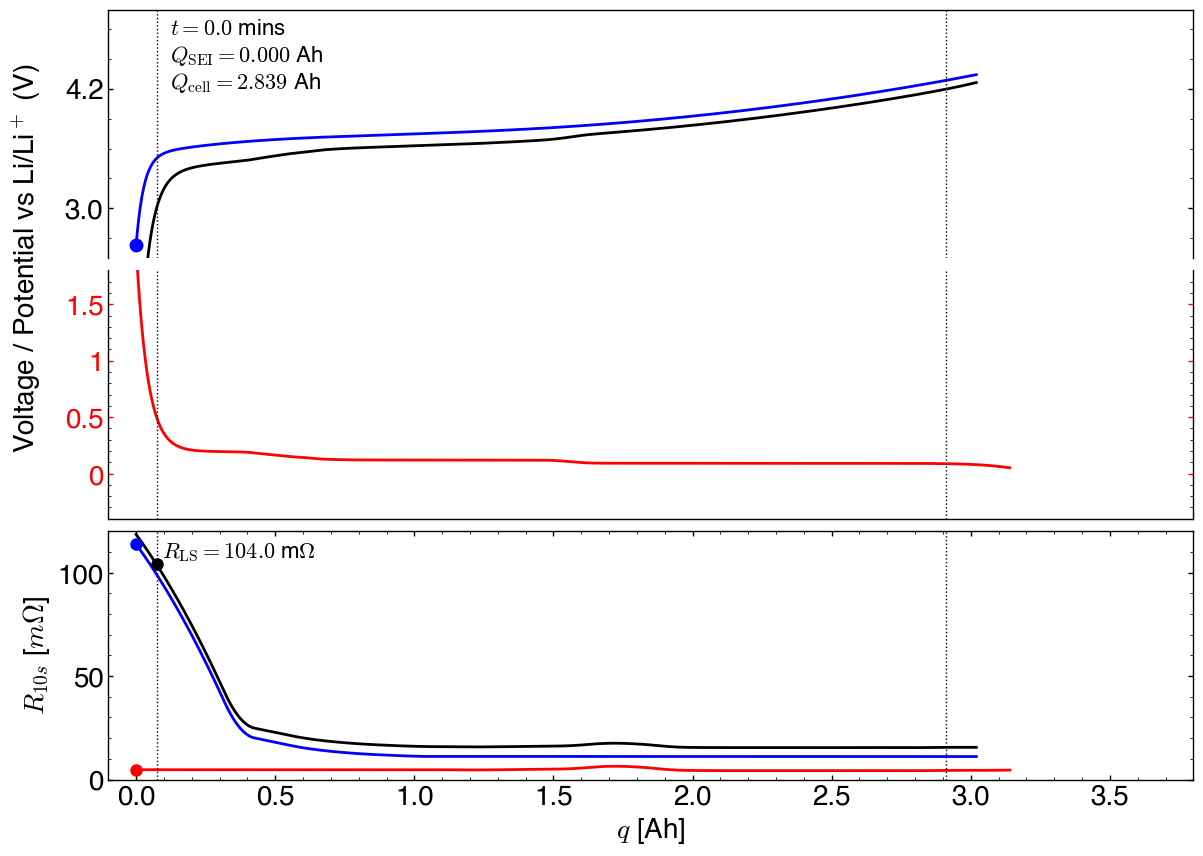

In [15]:
type = 'res'
interval_ms = 100

fig, axs, th = setup(type, figsize=())

ani = FuncAnimation(fig, animate, frames=num_frames,
                    fargs=(axs, type, th, sim1_out, interval_ms),
                    interval=interval_ms)

writergif = PillowWriter(fps=30)

ani.save(r'animation_base.gif', writer=writergif)

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_8069/4276634215.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ani.save(r'animation_fast.gif', writer=writergif)
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


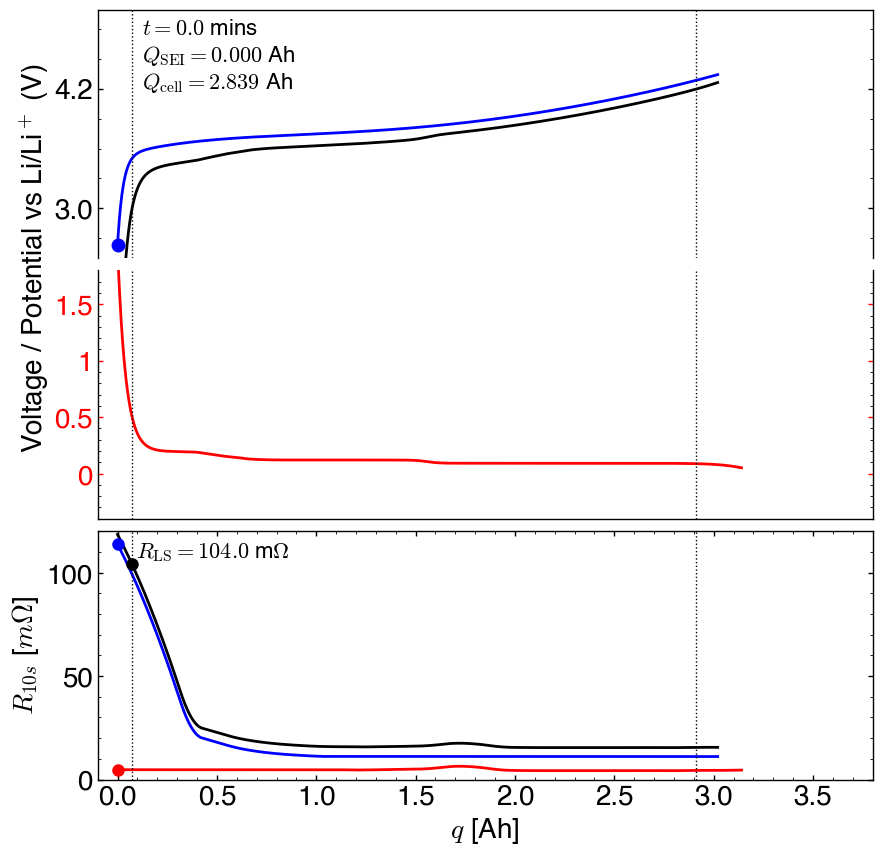

In [19]:
type = 'res'
interval_ms = 100


fig, axs, th = setup(type, figsize=(10,10))

ani = FuncAnimation(fig, animate, frames=num_frames+20,
                    fargs=(axs, type, th, sim2_out, interval_ms),
                    interval=interval_ms)

writergif = PillowWriter(fps=30)

ani.save(r'animation_fast.gif', writer=writergif)